In [6]:
# sklearn
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
import lightgbm as lgb

# xgboost
from xgboost import XGBClassifier

# utilities
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from utils import * # import all existing functions from file utils.py
%load_ext autoreload
%autoreload 2

# preferences
pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
df = pd.read_csv('../../data_p5/corpus_processed.csv', index_col=0)

In [8]:
df = df[['rating','lem','stem','noun','adj','adv','verb','characters','tokens','words','sentences','avg_word_len','avg_sent_len']]
df.head(3)

,rating,lem,stem,noun,adj,adv,verb,characters,tokens,words,sentences,avg_word_len,avg_sent_len
0,Neutral,"['cafe', 'hotel', 'deal', 'get', 'free', 'brea...","['cafe', 'hotel', 'deal', 'get', 'free', 'brea...",0.474227,0.226804,0.092784,0.154639,1041,97,196,11,5.311224,17.818182
1,Negative,"['went', 'food', 'coupon', 'didnt', 'want', 'w...","['went', 'food', 'coupon', 'didnt', 'want', 'w...",0.492958,0.197183,0.070423,0.211268,752,71,140,10,5.371429,14.000000
2,Negative,"['guy', 'aware', 'majority', 'place', 'closed'...","['guy', 'awar', 'major', 'place', 'close', 'ca...",0.484848,0.151515,0.090909,0.272727,434,33,78,6,5.564103,13.000000


In [9]:
# seperate target from features 

X = df.drop(columns=['rating'])
y = df['rating']

# splitting before vectorizing:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [11]:
# vectorize with TFIDF

vectorizer = TfidfVectorizer(ngram_range=(1, 3),   # include uni 2-gram and 3-rams only
                                max_df=.99, min_df=.01)  # drop top/bottom most common tokens 

In [12]:
tfidf_train = vectorizer.fit_transform(X_train['lem'])
tfidf_test = vectorizer.transform(X_test['lem'])

In [13]:
tfidf_train.shape

(30325, 856)

In [132]:
# # vectorize with TFIDF

# vectorizer = TfidfVectorizer(ngram_range=(1, 3),   # include uni and 3-rams only
#                                 max_df=.999, min_df=.001)  # drop top/bottom most common tokens 

In [133]:
# tfidf_train = vectorizer.fit_transform(X_train['lem'])
# tfidf_test = vectorizer.transform(X_test['lem'])

In [134]:
# tfidf_train_1.shape

In [14]:
# drop lemmas and stems

X_train = X_train.drop(columns=['lem'])
X_test = X_test.drop(columns=['lem'])
X_train = X_train.drop(columns=['stem'])
X_test = X_test.drop(columns=['stem'])

In [15]:
non_zero_cols = tfidf_train.nnz / float(tfidf_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_train.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 30.100643033800495
Percentage of columns containing 0: 0.96483569739042


In [16]:
# convert tfidf to array and concatenate train and test sets

X_train = pd.concat([pd.DataFrame(tfidf_train.toarray().T,  index = vectorizer.get_feature_names()).T, X_train.reset_index()], axis = 1)
X_test = pd.concat([pd.DataFrame(tfidf_test.toarray().T,  index = vectorizer.get_feature_names()).T, X_test.reset_index()], axis = 1)

In [17]:
# drop extra index

X_train = X_train.drop(columns='index')
X_test = X_test.drop(columns='index')

In [18]:
X_train.head(3).iloc[:, -20:]

,wrong,year,yelp,yes,yet,york,youll,young,youre,yummy,noun,adj,adv,verb,characters,tokens,words,sentences,avg_word_len,avg_sent_len
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.525000,0.075000,0.025000,0.300000,377,40,65,6,5.800000,10.833333
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.509804,0.176471,0.039216,0.254902,576,51,111,7,5.189189,15.857143
2,0.075861,0.070965,0.0,0.0,0.0,0.0,0.0,0.0,0.132345,0.0,0.483607,0.163934,0.049180,0.204918,1328,122,258,4,5.147287,64.500000


# Base Line Models

## Random Forest Vanilla Model

In [19]:
rf_classifier = RandomForestClassifier(random_state=32)
rf_classifier.fit(X_train, y_train)

rf_test_preds = rf_classifier.predict(X_test)
rf_train_preds = rf_classifier.predict(X_train)

metrics(rf_train_preds, y_train, rf_test_preds, y_test)

Training Accuracy:	1.0 	Testing Accuracy:	0.789
Training Precision:	1.0 	Testing Precision:	0.7547
Training Recall:	1.0 	Testing Recall:		0.789
Training F1:		1.0 	Testing F1:		0.7392


## XGBoost Vanilla Model

In [20]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

xgb_test_preds = xgb.predict(X_test)
xgb_train_preds = xgb.predict(X_train)

metrics(xgb_train_preds, y_train, xgb_test_preds, y_test)

[21:18:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:	0.9104 	Testing Accuracy:	0.8127
Training Precision:	0.9129 	Testing Precision:	0.7864
Training Recall:	0.9104 	Testing Recall:		0.8127
Training F1:		0.9033 	Testing F1:		0.7875


## LightGBM Vanilla Model

In [21]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)

lgbm_test_preds = lmgb.predict(X_test)
lgbm_train_preds = lmgb.predict(X_train)

metrics(lgbm_train_preds, y_train, lgbm_test_preds, y_test)

Training Accuracy:	0.8845 	Testing Accuracy:	0.8138
Training Precision:	0.8822 	Testing Precision:	0.7893
Training Recall:	0.8845 	Testing Recall:		0.8138
Training F1:		0.8739 	Testing F1:		0.7899


## Optimize random forest, XGBoost, and SVM hyperparameters with gridsearch

In [ ]:
# # RANDOM FOREST GRID SEARCH

# # create dictionary of hyperparameters to tune
# param_grid = {'n_estimators': [100, 250],
#               'criterion': ['gini', 'entropy'],
#               'max_depth': [None, 2, 10],
#               'max_features': [None, 4, 16, 24],
#               'min_samples_split' = [2, 4, 8, 16],
#               'min_samples_leaf' = [2, 4, 8]
#              }

# # create grid search object and fit to data
# grid_forest = GridSearchCV(RandomForestClassifier(random_state=32),
#                            param_grid,
#                            cv=2,
#                            scoring='f1',
#                            verbose=1,
#                            n_jobs=-1)

# grid_forest.fit(X_train, y_train)

# # pickle grid hyperparameters
# pickle_out = open("../pickles/rf_grid.pickle","wb")
# pickle.dump(grid_forest, pickle_out)
# pickle_out.close()

In [ ]:
# # XGBOOST GRID SEARCH"""

# # create dictionary of hyperparameters to tune
# param_grid = {'learning_rate': [0.1, 0.01],
#               'max_depth': [None, 2, 4, 10],
#               'min_child_weight': [1, 2, 3],
#               'subsample': [0.5, 0.7],
#               'n_estimators': [100, 300]}

# # create grid search object and fit to data
# grid_boost = GridSearchCV(XGBClassifier(random_state=32),
#                           param_grid,
#                           cv=2,
#                           scoring='f1',
#                           verbose=1,
#                           n_jobs=-1)

# grid_boost.fit(X_train, y_train)

# # pickle grid hyperparameters
# pickle_out = open("pickles/xgb_grid.pickle","wb")
# pickle.dump(grid_boost, pickle_out)
# pickle_out.close()

In [ ]:
# # LightGBM regression GRID SEARCH

# # create dictionary of hyperparameters to tune
# param_grid = {'n_estimators': [240, 250, 255],
#                'boosting': ['gbdt', 'dart'],
#                 'colsample_bytree': [0.69, 0.7, 0.71],
#                 'max_depth': [13, 15, 17],
#                 'num_leaves': [15, 20, 25, 30],
#                 'min_split_gain': [0.42, 0.4, 0.43],
#                 'reg_alpha': [1.0, 1.1],
#                 'reg_lambda': [1.45, 1.5],
#                 'subsample': [0.7, 0.75],
#                 'subsample_freq': [20]
#                }

# # # create grid search object and fit to data
# grid_lgbm = GridSearchCV(LGBMClassifier(random_state=32),
#                         param_grid,
#                         cv=2,
#                         scoring='f1',
#                         verbose=1,
#                         n_jobs=-1,
#                         error_score=0)

# grid_lgbm.fit(X_train, y_train)

# # pickle grid hyperparameters
# pickle_out = open("../pickles/log_grid.pickle","wb")
# pickle.dump(grid_log, pickle_out)
# pickle_out.close()

## Load optimal hyperparamters and fit and predict on classifiers

In [22]:
# # load grid hyperparameters

# grid_forest = pd.read_pickle('../pickles/rf_grid.pickle')
# grid_boost = pd.read_pickle('../pickles/xgb_grid.pickle')
# grid_log = pd.read_pickle('../pickles/log_grid.pickle')

In [26]:
# """random forest"""
# # print random forest hyperparameters
# print("Random Forest:",
#       f"num estimators = {grid_forest.best_params_['n_estimators']},",
#       f"criterion = {grid_forest.best_params_['criterion']},",
#       f"max depth = {grid_forest.best_params_['max_depth']},",
#       f"max features = {grid_forest.best_params_['max_features']}")

# # instantiate random forest classifier
# rf_classifier = RandomForestClassifier(criterion=grid_forest.best_params_['criterion'],
#                                        max_depth=grid_forest.best_params_['max_depth'],
#                                        max_features=grid_forest.best_params_['max_features'],
#                                        n_estimators=grid_forest.best_params_['n_estimators'],
#                                        random_state=42)

# # fit and predict on random forest classifier
# rf_classifier.fit(X_train, y_train)
# rf_train_preds = rf_classifier.predict(X_train)
# rf_test_preds = rf_classifier.predict(X_test)

Random Forest: num estimators = 100, criterion = gini, max depth = None, max features = None


In [22]:
# """xgboost"""
# # print xgboost hyperparameters
# print("XGBoost:",
#       f"learning rate = {grid_boost.best_params_['learning_rate']},",
#       f"max depth = {grid_boost.best_params_['max_depth']},",
#       f"min child weight = {grid_boost.best_params_['min_child_weight']},",
#       f"subsample = {grid_boost.best_params_['subsample']},",
#       f"num estimators = {grid_boost.best_params_['n_estimators']}")

# # instantiate xgboost classifier
# xgb_classifier = XGBClassifier(learning_rate=grid_boost.best_params_['learning_rate'],
#                                max_depth=grid_boost.best_params_['max_depth'],
#                                max_child_weight=grid_boost.best_params_['min_child_weight'],
#                                subsample=grid_boost.best_params_['subsample'],
#                                n_estimators=grid_boost.best_params_['n_estimators'],
#                                random_state=42)

# # fit and predict on xgboost classifier
# xgb_classifier.fit(X_train, y_train)
# xgb_train_preds = xgb_classifier.predict(X_train)
# xgb_test_preds = xgb_classifier.predict(X_test)

In [23]:
# """logistic regression vector machine"""

# # print LogReg hyperparameters
# print("LogReg:",
#       f"C = {grid_log.best_params_['C']},",
#       f"max_iter = {grid_log.best_params_['max_iter']}",
#       f"solver = {grid_log.best_params_['solver']}"),  

# # instantiate LogReg classifier
# log_classifier = LogisticRegression(
#                               C = grid_log.best_params_['C'],
#                               max_iter = grid_log.best_params_['max_iter'], 
#                               solver = grid_log.best_params_['solver'],
#                               random_state = 42)

# # fit and predict on logreg classifier
# log_classifier.fit(X_train, y_train)
# log_train_preds = log_classifier.predict(X_train)
# log_test_preds = log_classifier.predict(X_test)

## Results and Evaluation

In [24]:
# print('RANDOM FOREST: \n')
# metrics(rf_train_preds, y_train, rf_test_preds, y_test)

# print('\n\nXGBOOST: \n')
# metrics(xgb_train_preds, y_train, xgb_test_preds, y_test)

# print('\n\nLogistic Regression: \n')
# metrics(log_train_preds, y_train, log_test_preds, y_test)

## Confusion Matrix

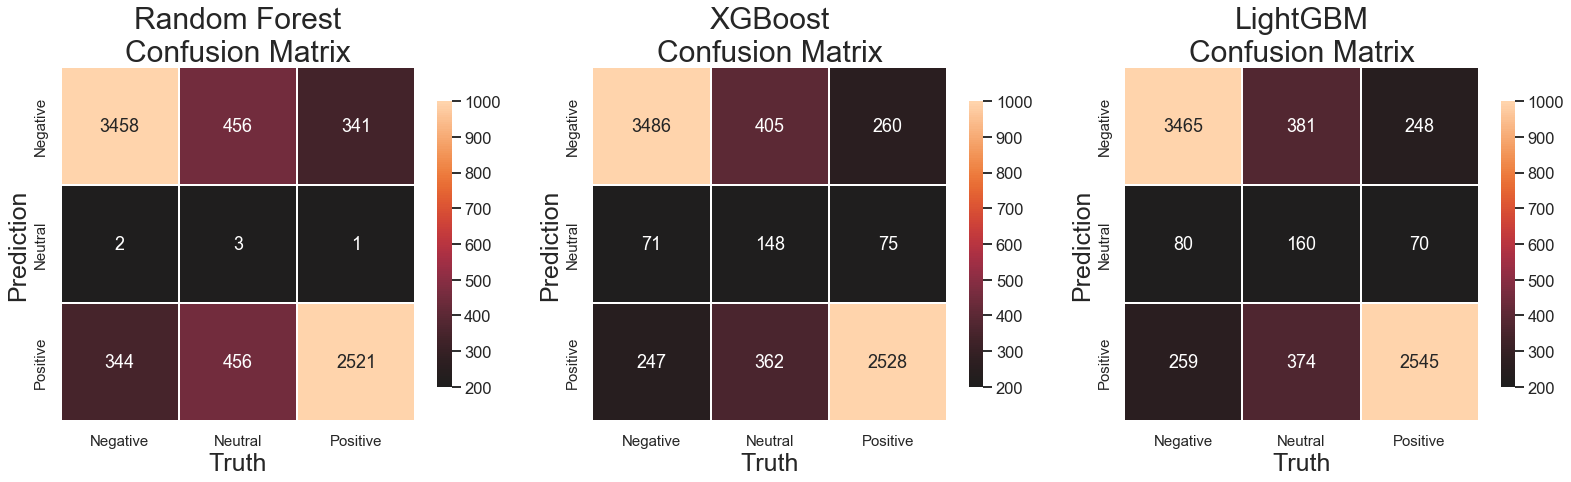

In [27]:
sns.color_palette("bright")
sns.set_context("talk")

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(27, 7))


"""random forest"""
# plot random forest confusion matrix
sns.heatmap(confusion_matrix(y_test, rf_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cbar_kws={"shrink": .75},
### Evaluate model metrics
            ax=ax[0]).set_title('Random Forest\nConfusion Matrix', fontsize=30)

ax[0].set_xlabel('Truth', fontsize=25)
ax[0].set_ylabel('Prediction', fontsize=25)
ax[0].set_xticklabels(['Negative', 'Neutral', 'Positive'], fontsize=15)
ax[0].set_yticklabels(['Negative', 'Neutral', 'Positive'], va='center', fontsize=15)


"""xgboost"""
# plot xgboost confusion matrix
sns.heatmap(confusion_matrix(y_test, xgb_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cbar_kws={"shrink": .75},
            ax=ax[1]).set_title('XGBoost\nConfusion Matrix', fontsize=30)

ax[1].set_xlabel('Truth', fontsize=25)
ax[1].set_ylabel('Prediction', fontsize=25)
ax[1].set_xticklabels(['Negative', 'Neutral', 'Positive'], fontsize=15)
ax[1].set_yticklabels(['Negative', 'Neutral', 'Positive'], va='center', fontsize=15)


"""LMGB"""
# plot LogReg confusion matrix

sns.heatmap(confusion_matrix(y_test, lmgb_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cbar_kws={"shrink": .75},
            ax=ax[2]).set_title('LightGBM\nConfusion Matrix', fontsize=30)

ax[2].set_xlabel('Truth', fontsize=25)
ax[2].set_ylabel('Prediction', fontsize=25)
ax[2].set_xticklabels(['Negative', 'Neutral', 'Positive'], fontsize=15)
ax[2].set_yticklabels(['Negative', 'Neutral', 'Positive'], va='center', fontsize=15)


plt.savefig(fname='../images/conf_mtrx', bbox_inches='tight', pad_inches=.1)
plt.show()

## Feature Importance

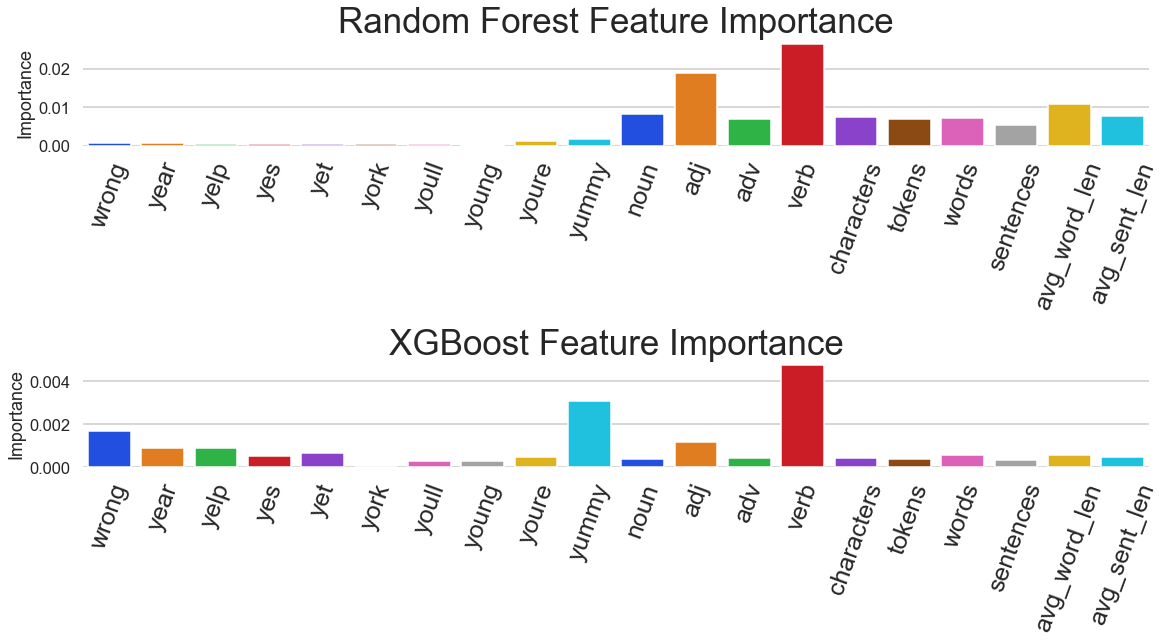

In [28]:
sns.color_palette("bright")
sns.set_style('whitegrid')
sns.set_context("paper")
sns.set_context("talk")

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 7))
fig.tight_layout()
plt.subplots_adjust(hspace=2)


"""random forest"""
# plot random forest feature importance
sns.despine(left=True, bottom=True)
sns.barplot(x=X_train.columns[-20:],
            y=rf_classifier.feature_importances_[-20:],
            palette='bright',
            ax=ax[0]).set_title('Random Forest Feature Importance', fontsize=35)

ax[0].set_ylabel('Importance')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=70, fontsize=25)

"""xgboost"""
# plot xgboost feature importance
sns.despine(left=True, bottom=True)
sns.barplot(x=X_train.columns[-20:],
            y=xgb.feature_importances_[-20:],
            palette='bright',
            ax=ax[1]).set_title('XGBoost Feature Importance', fontsize=35)

ax[1].set_ylabel('Importance')
ax[1].set_xticklabels(ax[0].get_xticklabels(), rotation=70, fontsize=25)

    
plt.savefig(fname='../images/importance', bbox_inches='tight', pad_inches=.1)
plt.show()